In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from ngram import *
from baselines import *
from error_analysis import *
from deep_learning import *
pd.options.mode.chained_assignment = None


Using TensorFlow backend.


### Load Annotated Data

In [2]:
task = 'recipient'
xtype = 'ngrams'
ytype = 'empirical_dist'
n_classes = 2

time: 1.98 ms


In [3]:
data = load_comments_and_labels(task)

time: 2min 1s


### NGram Preprocessing

In [4]:
feature_pipeline =  Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('to_dense', DenseTransformer()), 
])

X_comments, _ = assemble_data(data, 'comments', ytype, splits = ['train'])
preprocessor = feature_pipeline.fit(X_comments)
data = apply_transform(data, 'comments', preprocessor, xtype)

X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 4min 34s


### Define Model

In [5]:
clf =  KerasClassifier(build_fn=make_MLP, output_dim = n_classes, input_dim = 10000)

time: 12.6 ms


### Deep EDP Hyper-Parameter tuning

In [28]:
# Deep EDP

param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (1,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
30341/30341 [==============================] - 6s     
Epoch 1/1
30341/30341 [==============================] - 6s     
Epoch 1/1
30341/30341 [==============================] - 6s     
Epoch 1/1
30341/30341 [==============================] - 7s     

Best parameters set found:
{'batch_size': 100, 'l': 0, 'nb_epoch': 1, 'layers': [50, 10]} 0.969898083321


Grid scores:
0.96990 (+/-0.00000) for {'batch_size': 100, 'l': 0, 'nb_epoch': 1, 'layers': [50, 10]}
0.96727 (+/-0.00000) for {'batch_size': 100, 'l': 1e-05, 'nb_epoch': 1, 'layers': [50, 10]}
0.96517 (+/-0.00000) for {'batch_size': 100, 'l': 0.0001, 'nb_epoch': 1, 'layers': [50, 10]}
0.95914 (+/-0.00000) for {'batch_size': 100, 'l': 0.001, 'nb_epoch': 1, 'layers': [50, 10]}
time: 4min 42s


Seems, like we don't need to regularize at one epoch. Lets try more epochs.

In [5]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
70793/70793 [==============================] - 25s - loss: 0.0844 - acc: 0.9479    
Epoch 2/2
30341/30341 [==============================] - 5s     
Epoch 1/2
70793/70793 [==============================] - 25s - loss: 0.0957 - acc: 0.9483    
Epoch 2/2
30341/30341 [==============================] - 5s     
Epoch 1/2
70793/70793 [==============================] - 26s - loss: 0.1062 - acc: 0.9316    
Epoch 2/2
30341/30341 [==============================] - 6s     
Epoch 1/2
70793/70793 [==============================] - 26s - loss: 0.1779 - acc: 0.9244    
Epoch 2/2
30341/30341 [==============================] - 5s     

Best parameters set found:
{'batch_size': 100, 'nb_epoch': 2, 'l': 0, 'layers': [50, 10]} 0.974316704132


Grid scores:
0.97432 (+/-0.00000) for {'batch_size': 100, 'nb_epoch': 2, 'l': 0, 'layers': [50, 10]}
0.97292 (+/-0.00000) for {'batch_size': 100, 'nb_epoch': 2, 'l': 1e-05, 'layers': [50, 10]}
0.96489 (+/-0.00000) for {'batch_size': 100, 'nb_epoch': 2, 'l'

Same pattern. Results improved for lower reg. Lets try more epochs.

In [6]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (4,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/4
70793/70793 [==============================] - 26s - loss: 0.0831 - acc: 0.9489    
Epoch 2/4
70793/70793 [==============================] - 21s - loss: 0.0496 - acc: 0.9615    
Epoch 3/4
70793/70793 [==============================] - 22s - loss: 0.0455 - acc: 0.9653    
Epoch 4/4
30341/30341 [==============================] - 5s     
Epoch 1/4
70793/70793 [==============================] - 24s - loss: 0.0947 - acc: 0.9476    
Epoch 2/4
70793/70793 [==============================] - 21s - loss: 0.0554 - acc: 0.9606    
Epoch 3/4
70793/70793 [==============================] - 22s - loss: 0.0527 - acc: 0.9623    
Epoch 4/4
30341/30341 [==============================] - 5s     
Epoch 1/4
70793/70793 [==============================] - 25s - loss: 0.1087 - acc: 0.9460    
Epoch 2/4
70793/70793 [==============================] - 22s - loss: 0.0633 - acc: 0.9585    
Epoch 3/4
70793/70793 [==============================] - 22s - loss: 0.0608 - acc: 0.9605    
Epoch 4/4
30341/30341 [=

Same pattern still, although performance went a bit down. Lets push the epochs even further.

In [8]:
# Deep EDP
param_grid = {
    'l': (0.00001,),
    'nb_epoch' : (8,16),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/8
70793/70793 [==============================] - 26s - loss: 0.0928 - acc: 0.9489    
Epoch 2/8
70793/70793 [==============================] - 23s - loss: 0.0550 - acc: 0.9613    
Epoch 3/8
70793/70793 [==============================] - 23s - loss: 0.0521 - acc: 0.9627    
Epoch 4/8
70793/70793 [==============================] - 23s - loss: 0.0500 - acc: 0.9639    
Epoch 5/8
70793/70793 [==============================] - 24s - loss: 0.0483 - acc: 0.9655    
Epoch 6/8
70793/70793 [==============================] - 24s - loss: 0.0467 - acc: 0.9672    
Epoch 7/8
70793/70793 [==============================] - 22s - loss: 0.0451 - acc: 0.9685    
Epoch 8/8
30341/30341 [==============================] - 5s     
Epoch 1/16
70793/70793 [==============================] - 25s - loss: 0.0936 - acc: 0.9460    
Epoch 2/16
70793/70793 [==============================] - 22s - loss: 0.0552 - acc: 0.9617    
Epoch 3/16
70793/70793 [==============================] - 22s - loss: 0.0524 - acc: 0.9

Right now, 2 epochs and no regularization is best. Lets add more layers.

In [9]:
# Deep EDP
param_grid = {
    'l': (0.00001,),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 50],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
70793/70793 [==============================] - 27s - loss: 0.0837 - acc: 0.9481    
Epoch 2/2
30341/30341 [==============================] - 6s     

Best parameters set found:
{'batch_size': 100, 'nb_epoch': 2, 'l': 1e-05, 'layers': [50, 50]} 0.972172736981


Grid scores:
0.97217 (+/-0.00000) for {'batch_size': 100, 'nb_epoch': 2, 'l': 1e-05, 'layers': [50, 50]}
time: 1min 14s


Adding more layers did not help.

### Linear EDP Tuning

In [13]:
# Linear EDP
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
70793/70793 [==============================] - 13s - loss: 0.1045 - acc: 0.9396    
Epoch 2/2
70793/70793 [==============================] - 13s - loss: 0.1070 - acc: 0.9376    
Epoch 2/4
70793/70793 [==============================] - 8s - loss: 0.0637 - acc: 0.9536     
Epoch 3/4
70793/70793 [==============================] - 8s - loss: 0.0569 - acc: 0.9568     
Epoch 4/4
70793/70793 [==============================] - 13s - loss: 0.1062 - acc: 0.9384    
Epoch 2/8
70793/70793 [==============================] - 9s - loss: 0.0640 - acc: 0.9530     
Epoch 3/8
70793/70793 [==============================] - 8s - loss: 0.0574 - acc: 0.9569     
Epoch 4/8
70793/70793 [==============================] - 9s - loss: 0.0545 - acc: 0.9584     
Epoch 5/8
70793/70793 [==============================] - 9s - loss: 0.0527 - acc: 0.9595     
Epoch 6/8
70793/70793 [==============================] - 9s - loss: 0.0515 - acc: 0.9603     
Epoch 7/8
70793/70793 [==============================] - 9s 

We won't bother regularizing. Lets just tune epochs. Seems to max out at 8.

### Linear OH Tuning

In [14]:
# Linear OH
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
70793/70793 [==============================] - 14s - loss: 0.2185 - acc: 0.9343    
Epoch 2/2
70793/70793 [==============================] - 13s - loss: 0.2219 - acc: 0.9317    
Epoch 2/4
70793/70793 [==============================] - 9s - loss: 0.1497 - acc: 0.9489     
Epoch 3/4
70793/70793 [==============================] - 10s - loss: 0.1292 - acc: 0.9541    
Epoch 4/4
70793/70793 [==============================] - 14s - loss: 0.2169 - acc: 0.9336    
Epoch 2/8
70793/70793 [==============================] - 10s - loss: 0.1469 - acc: 0.9498    
Epoch 3/8
70793/70793 [==============================] - 10s - loss: 0.1270 - acc: 0.9546    
Epoch 4/8
70793/70793 [==============================] - 10s - loss: 0.1165 - acc: 0.9568    
Epoch 5/8
70793/70793 [==============================] - 10s - loss: 0.1099 - acc: 0.9588    
Epoch 6/8
70793/70793 [==============================] - 10s - loss: 0.1052 - acc: 0.9605    
Epoch 7/8
70793/70793 [==============================] - 10s

Lets try more epochs.

In [16]:
param_grid = {
    'l': (0,),
    'nb_epoch' : (24, 32),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/24
70793/70793 [==============================] - 13s - loss: 0.2180 - acc: 0.9332    
Epoch 2/24
70793/70793 [==============================] - 9s - loss: 0.1488 - acc: 0.9494     
Epoch 3/24
70793/70793 [==============================] - 9s - loss: 0.1294 - acc: 0.9537     
Epoch 4/24
70793/70793 [==============================] - 9s - loss: 0.1191 - acc: 0.9563     
Epoch 5/24
70793/70793 [==============================] - 9s - loss: 0.1128 - acc: 0.9581     
Epoch 6/24
70793/70793 [==============================] - 9s - loss: 0.1082 - acc: 0.9596     
Epoch 7/24
70793/70793 [==============================] - 10s - loss: 0.1048 - acc: 0.9606    
Epoch 8/24
70793/70793 [==============================] - 10s - loss: 0.1020 - acc: 0.9614    
Epoch 9/24
70793/70793 [==============================] - 9s - loss: 0.0997 - acc: 0.9620     
Epoch 10/24
70793/70793 [==============================] - 9s - loss: 0.0977 - acc: 0.9630     
Epoch 11/24
70793/70793 [========================

ok, so 24 is enough for oh.

### Eval SKlearn

In [6]:
sk_model = LogisticRegression(C = 5.0,  solver = 'sag')
sk_model.fit(X_train, y_train.argmax(axis = 1))
roc_df, spearman_df = test_cross(sk_model, data, xtype)

time: 2min 37s


In [7]:
roc_df

,random,blocked,both
user,0.994495,0.949073,0.961200
article,0.971179,0.961371,0.970168
both,0.983033,0.959499,0.969617


time: 54.9 ms


In [8]:
spearman_df

,random,blocked,both
user,0.199411,0.650519,0.598965
article,0.141854,0.434141,0.355467
both,0.193016,0.618578,0.545708


time: 6.66 ms


### Eval OH

In [9]:
oh_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 24,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
oh_linear_model.fit(X_train, one_hot(y_train))
roc_df, spearman_df = test_cross(oh_linear_model, data, xtype)

Epoch 1/24
71009/71009 [==============================] - 15s - loss: 0.2133 - acc: 0.9359    
Epoch 2/24
71009/71009 [==============================] - 12s - loss: 0.1441 - acc: 0.9511    
Epoch 3/24
71009/71009 [==============================] - 12s - loss: 0.1241 - acc: 0.9554    
Epoch 4/24
71009/71009 [==============================] - 13s - loss: 0.1135 - acc: 0.9582    
Epoch 5/24
71009/71009 [==============================] - 12s - loss: 0.1069 - acc: 0.9599    
Epoch 6/24
71009/71009 [==============================] - 13s - loss: 0.1022 - acc: 0.9616    
Epoch 7/24
71009/71009 [==============================] - 13s - loss: 0.0987 - acc: 0.9625    
Epoch 8/24
71009/71009 [==============================] - 16s - loss: 0.0959 - acc: 0.9634    
Epoch 9/24
71009/71009 [==============================] - 15s - loss: 0.0935 - acc: 0.9642    
Epoch 10/24
71009/71009 [==============================] - 16s - loss: 0.0915 - acc: 0.9652    
Epoch 11/24
71009/71009 [========================

In [10]:
roc_df

,random,blocked,both
user,0.993791,0.946814,0.959405
article,0.959110,0.955523,0.964508
both,0.978141,0.957059,0.967490


time: 25.4 ms


In [11]:
spearman_df

,random,blocked,both
user,0.176883,0.635657,0.587431
article,0.126734,0.406099,0.331456
both,0.171392,0.600709,0.528904


time: 38.1 ms


### Eval Linear EDP

In [12]:
ed_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 8,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
ed_linear_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(ed_linear_model, data, xtype)

Epoch 1/8
71009/71009 [==============================] - 21s - loss: 0.1429 - acc: 0.9394    
Epoch 2/8
71009/71009 [==============================] - 15s - loss: 0.0903 - acc: 0.9547    
Epoch 3/8
71009/71009 [==============================] - 14s - loss: 0.0807 - acc: 0.9576    
Epoch 4/8
71009/71009 [==============================] - 14s - loss: 0.0769 - acc: 0.9594    
Epoch 5/8
71009/71009 [==============================] - 15s - loss: 0.0746 - acc: 0.9610    
Epoch 6/8
71009/71009 [==============================] - 15s - loss: 0.0730 - acc: 0.9616    
Epoch 7/8
71009/71009 [==============================] - 15s - loss: 0.0718 - acc: 0.9622    
Epoch 8/8
23668/23668 [==============================] - 3s     
time: 2min 55s


In [13]:
roc_df

,random,blocked,both
user,0.994860,0.947449,0.961308
article,0.977303,0.960489,0.970652
both,0.985309,0.958961,0.970301


time: 20.7 ms


In [14]:
spearman_df

,random,blocked,both
user,0.251074,0.676574,0.645185
article,0.179259,0.474345,0.395362
both,0.236284,0.657584,0.594054


time: 14.7 ms


### Eval Deep EDP

In [15]:
deep_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 2,
                               batch_size = 100,
                               l = 0.000001, 
                               layers = [50, 10])
deep_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(deep_model, data, xtype)

Epoch 1/2
71009/71009 [==============================] - 40s - loss: 0.1179 - acc: 0.9335    
Epoch 2/2
23668/23668 [==============================] - 6s     
time: 2min 19s


In [16]:
roc_df

,random,blocked,both
user,0.996074,0.947479,0.961482
article,0.985435,0.962880,0.972930
both,0.989515,0.958800,0.970352


time: 17.9 ms


In [17]:
spearman_df

,random,blocked,both
user,0.262938,0.684797,0.649111
article,0.182304,0.483905,0.402879
both,0.245107,0.661445,0.596676


time: 9.22 ms


### Check Calibration

23668/23668 [==============================] - 3s     


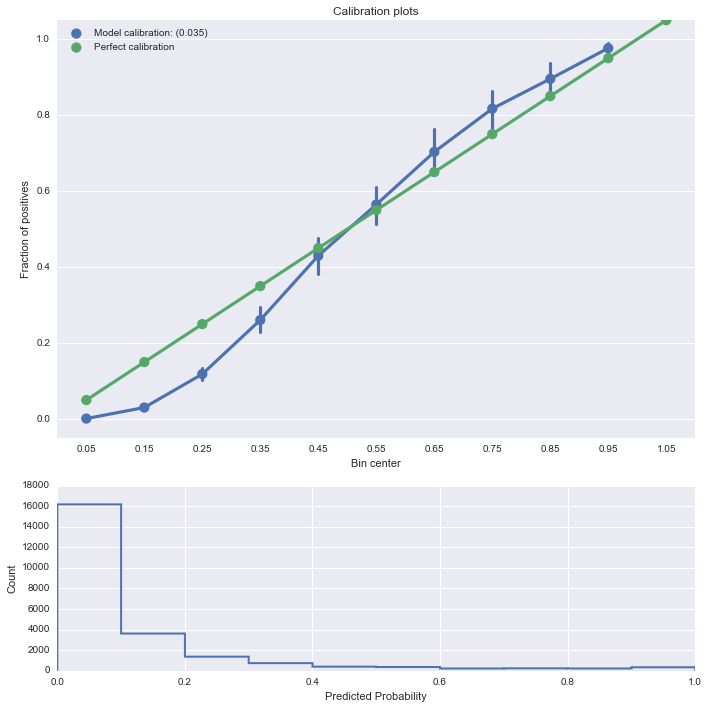

time: 5.64 s


In [23]:
y_test_oh = one_hot(y_test)
y_pred_ed = ed_linear_model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()